# IEEEP370 Deembedding
## Table of Content
* [Single-ended](#single-ended)
 * [Simulation of 2xThru, DUT and Fixture-DUT-Fixture](#se-preparation)
 * [IEEEP370_SE_NZC_2xthru without impedance correction](#nzc)
 * [IEEEP370_SE_ZC_2xthru with impedance correction](#zc)
 * [Single Ended Comparison with AICC De-Embedding Utility](#aicc)
* [Mixed mode](#mixed-mode)
 * [Simulation of 2xThru, DUT and Fixture-DUT-Fixture](#mm-preparation)
 * [IEEEP370_MM_NZC_2xthru without impedance correction](#mmnzc)
 * [IEEEP370_MM_ZC_2xthru with impedance correction](#mmzc)
 * [Mixed Mode Comparison with AICC De-Embedding Utility](#mmaicc)


## Introduction

The [IEEEP370 standards](https://standards.ieee.org/ieee/370/6165/) provides good practices for ensuring the quality of measured data for high-frequency electrical interconnects at frequencies up to 50 GHz. It recommends methods and processes for ensuring the accuracy and consistency of measured data for signals with frequency content up to 50 GHz, in particular for removing test fixture and instrumentation effects.

In the examples below, and following the standard proposal on labelling, a 2-port DUT have one fixture attached to each of its port. The fixture attached to the single-ended DUT port 1 is labeled as FIX-1. The fixture attached to the single-ended DUT port 2 is labeled as FIX-2. The name of the fixture is shortened to FIX and the composite structure as FIX-DUT-FIX. The combination of the DUT and fixtures on either end is referred to as the composite structure or the FIX-DUT-FIX structure.

<img src="fix-dut-fix.svg" width="400"/>

The combination of just the two fixtures, such as a FIX-1 connected to a FIX-2, is referred to as a FIX-FIX structure or a *2x-Thru*.

<img src="fix-fix.svg" width="270"/>

The purpose of this notebook is to illustrate the `scikit-rf` implementation of the deembedding methods proposed within the  IEEE P370 standard to remove the test fixture effects.

First, let's make the necessary Python import statements:

In [1]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import  c, pi
from skrf.calibration import (IEEEP370_SE_NZC_2xThru, IEEEP370_MM_NZC_2xThru,
                              IEEEP370_SE_ZC_2xThru, IEEEP370_MM_ZC_2xThru,
                              IEEEP370)
from skrf.media import DefinedGammaZ0, MLine
rf.stylely()

## Single-ended <a class="anchor" id="single-ended"></a>
The algorithms can be used with 2-port single-ended networks.

### Simulation of 2xThru, DUT and Fixture-DUT-Fixture <a class="anchor" id="se-preparation"></a>
We use `scikit-rf` `MLine` media to simulate microstrip lines artifacts. This is convenient to vary parameters without leaving Python to operate another software to generate s-parameter files.

* `dut` is a Beatty structure with a 3xWidth microstrip segment connected left and right by two uniform 1xWidth microstrip.
* `fdf` is FIX-DUT-FIX, prolongating the DUT left and right lines (connector and launch not simulated).
* `s2xthru` is FIX-FIX and is the two prolongating lines connected in the middle without the DUT. For example purpose the width is changed by 8% to show the effect of such a mismatch in the deembedding process.

The target is to bisect `s2xthru` to get the left and right fixtures models and get DUT by deembedding from FIX-DUT-FIX.

The microstrip lines are inspired by [this example](./Time domain reflectometry, measurement vs simulation.ipynb).

In [2]:
directory = 'ieeep370deembedding/'
freq = rf.Frequency(10e-3, 10, 1000, 'GHz')
W   = 3.00e-3
H   = 1.55e-3
T   = 50e-6
ep_r = 4.459
tanD = 0.0183
f_epr_tand = 1e9

# microstrip segments
MSL1 = MLine(frequency=freq, z0_port=50, w=W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tanD, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')

# capacitive 3 x width Beatty structure
MSL2 = MLine(frequency=freq, z0_port=50, w=3*W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tanD, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')

# microstrip segment with a 10% variation of width
MSL3 = MLine(frequency=freq, z0_port=50, w=0.92*W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tanD, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')

# connector SMA edge PCB mount soldered
CONN = DefinedGammaZ0(frequency=freq, gamma = 1j* 2 * pi * freq.f / c, z0_port = 50)
z_conn = 53.2    # ohm, connector impedance
d_conn = 50      # ps,   connector discontinuity delay
connector = CONN.line(50, 'ps', z0 = z_conn)

# building DUT
dut =    MSL1.line(20e-3, 'm') \
      ** MSL2.line(20e-3, 'm') \
      ** MSL1.line(20e-3, 'm')
dut.name = 'DUT'

# building FIXTURE-DUT-FIXTURE
thru1 = MSL1.line(25e-3, 'm')
thru3 = MSL3.line(25e-3, 'm')
fdf     = connector ** thru1 ** dut ** thru1 ** connector
fdf.name = 'FIX-DUT-FIX'
# add some noise to make it more realistic
fdf.add_noise_polar(.001, .01)


# building FIXTURE-FIXTURE with a 8% width variation from FIXTURE-DUT-FIXTURE(2xthru)
s2xthru = connector ** thru3 ** thru3 ** connector
s2xthru.name = '2x-Thru'
# add some noise to make it more realistic
s2xthru.add_noise_polar(.001, .1)

# extrapolate to DC for time step
dut_dc = IEEEP370.extrapolate_to_dc(dut)
fdf_dc = IEEEP370.extrapolate_to_dc(fdf)
s2xthru_dc = IEEEP370.extrapolate_to_dc(s2xthru)
# set True to write .s2p files
if True:
    s2xthru.write_touchstone(directory + 'se_2xthru.s2p')
    fdf.write_touchstone(directory + 'se_fdf.s2p')

C:\Users\huser\kDrive2\prj\048-scikit-rf\scikit-rf\skrf\media\mline.py:276: RuntimeWarning: Conductor loss calculation invalid for lineheight t (5e-05)  < 3 * skin depth (2.0824376719439517e-05)
  self.alpha_conductor, self.alpha_dielectric = self.analyse_loss(


Looking at generated networks. The `_dc` networks were extraploated to DC to enable time step plot. The time shift of dut caused be the fixture and the 2xthru impedance mismatch are clearly visibles.

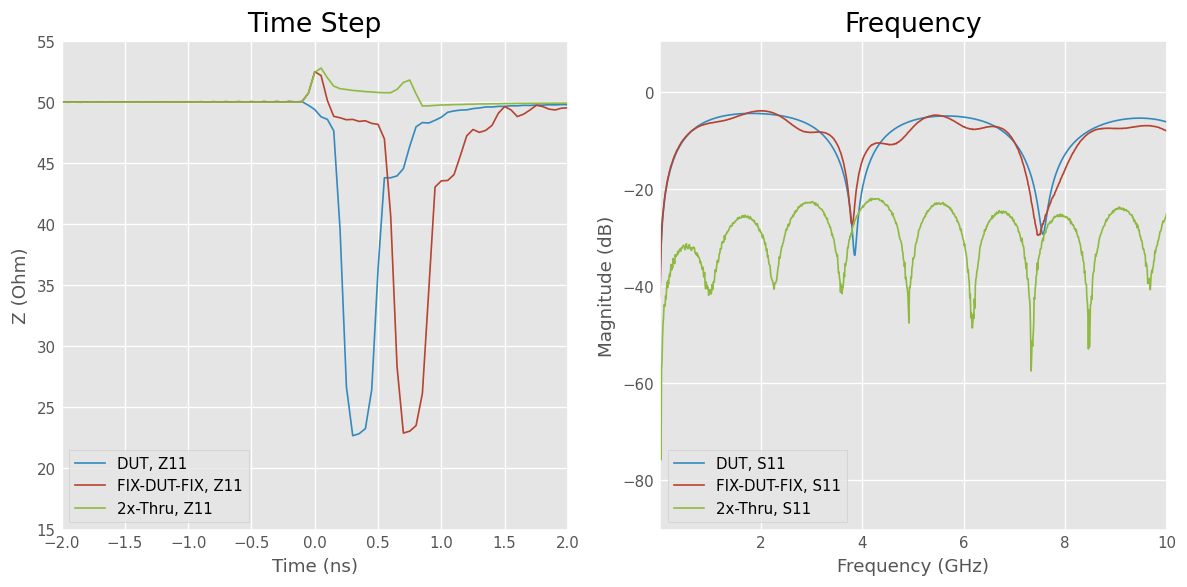

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Time Step')
dut_dc.plot_z_time_step(0, 0, ax = axs[0])
fdf_dc.plot_z_time_step(0, 0, ax = axs[0])
s2xthru_dc.plot_z_time_step(0, 0, ax = axs[0])
axs[0].set_xlim((-2, 2))
axs[0].set_ylim((15, 55))
axs[0].legend(loc = 'lower left')

axs[1].set_title('Frequency')
dut.plot_s_db(0, 0, ax = axs[1])
fdf.plot_s_db(0, 0, ax = axs[1])
s2xthru.plot_s_db(0, 0, ax = axs[1])
axs[1].legend(loc = 'lower left')
fig.tight_layout()

By testing some of the fixture electrical requirements (FER) of IEEE370, the fixture 2x-Thru is deemed Class A
compliant for frequencies below 10 GHz.

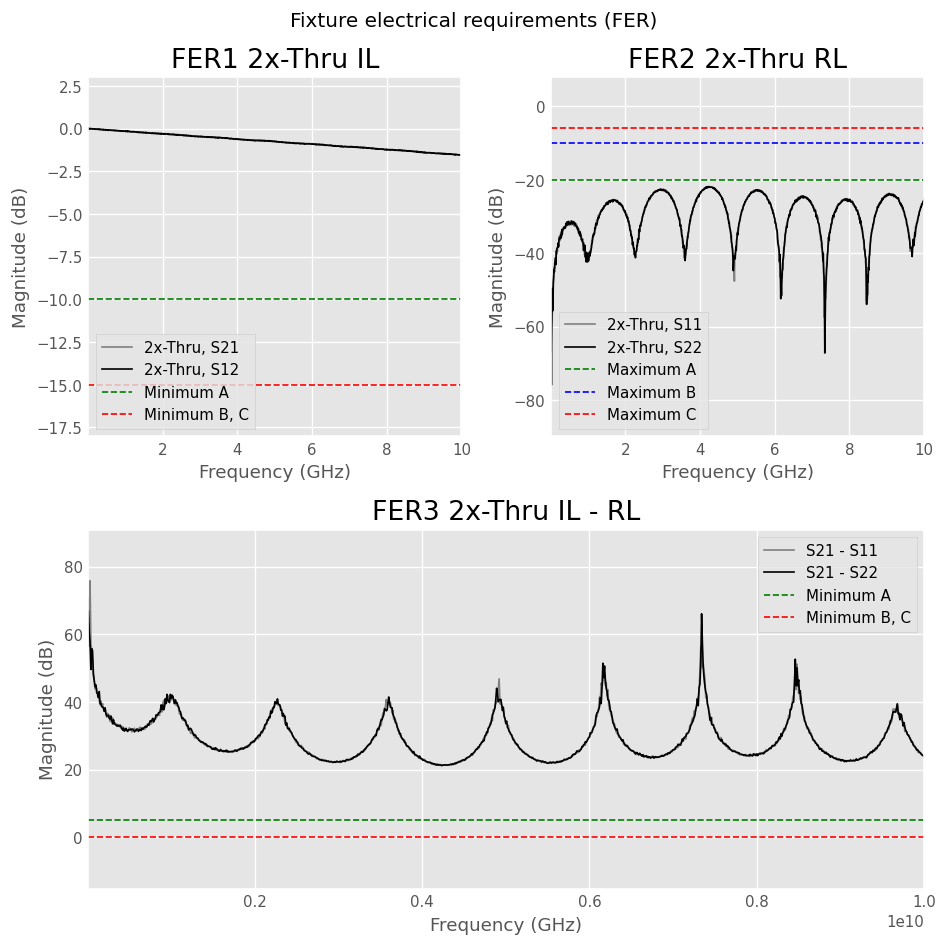

In [4]:
fig = IEEEP370.plot_check_se_fer_s(s2xthru)

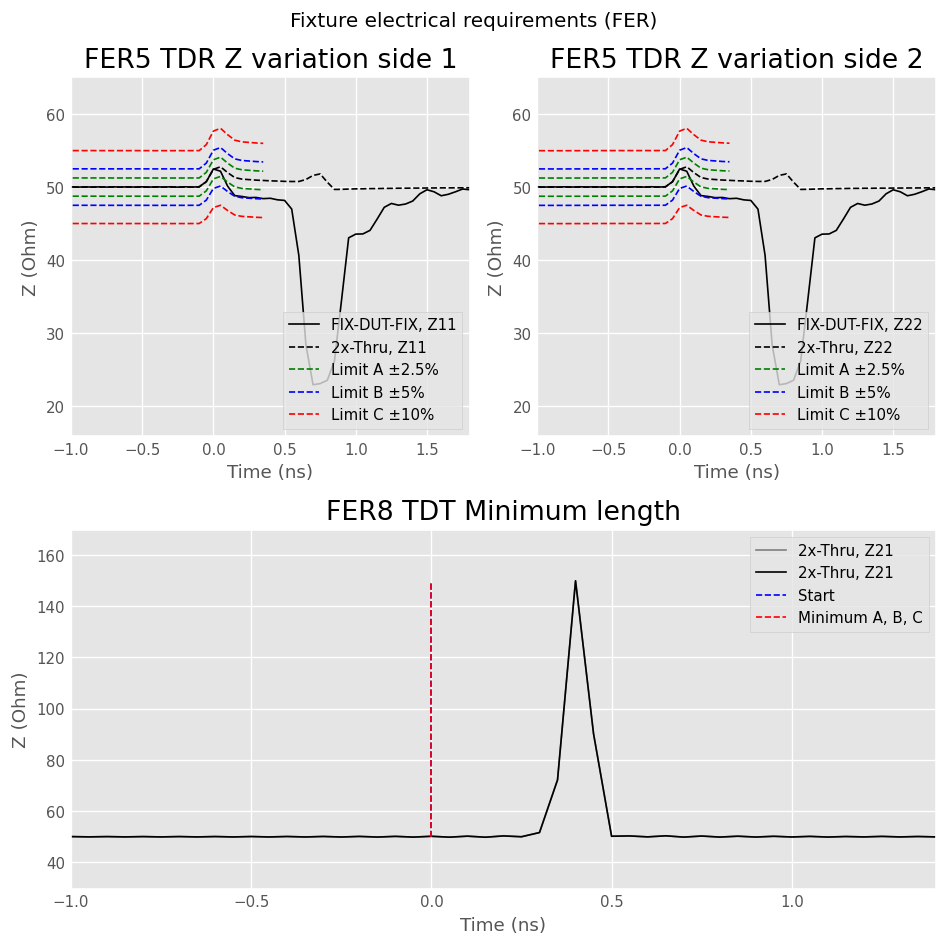

In [5]:
fig = IEEEP370.plot_check_se_fer_z(s2xthru, fdf)

### IEEEP370_SE_NZC_2xthru without impedance correction <a class="anchor" id="nzc"></a>
This method only takes 2x-Thru as input. It is quite simple and efficient but cannot correct for the difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX. Of course this difference is not wanted, but it could occurs depending manufacturing process or if the artefacts are not built on the same board.

IEEEP370 recommend following consistency checks:

* Self de-embedding of 2x-Thru with absolute magnitude of residual insertion loss < 0.1 dB and phase < 1 degree
* Compare the TDR of the fixture model to the FIX-DUT-FIX
 
  

C:\Users\huser\kDrive2\prj\048-scikit-rf\scikit-rf\skrf\mathFunctions.py:268: RuntimeWarning: divide by zero encountered in log10
  out = 20 * np.log10(z)


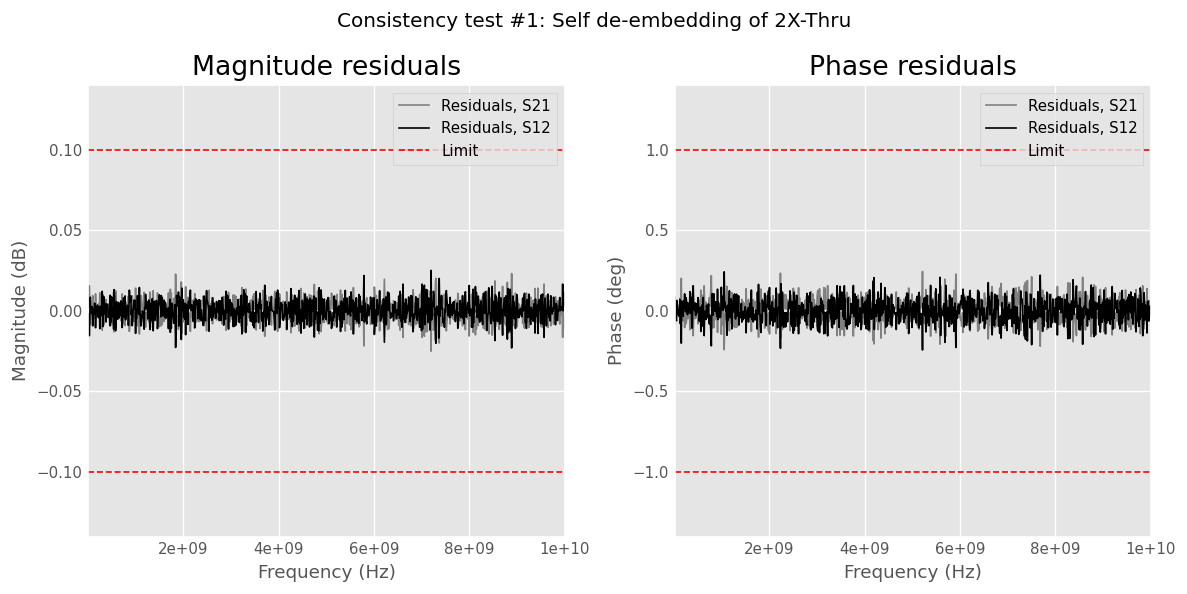

In [6]:
dm_nzc = IEEEP370_SE_NZC_2xThru(dummy_2xthru = s2xthru, name = '2xthru')
nzc_fix1 = dm_nzc.s_side1
nzc_fix1.name = 'nzc_FIX-1'
nzc_fix2 = dm_nzc.s_side2
nzc_fix2.name = 'nzc_FIX-2'
nzc_d_dut = dm_nzc.deembed(fdf)
nzc_d_dut.name = 'nzc_DUT'
nzc_fix1_dc = IEEEP370.extrapolate_to_dc(nzc_fix1)
nzc_d_dut_dc = IEEEP370.extrapolate_to_dc(nzc_d_dut)

fig, ax = dm_nzc.plot_check_residuals()

The agreement between fixtures models and 2xthru is excellent, as shown by magnitude and phase of residuals being much smaller than IEEEP370 ±0.1 dB and ±1° limits.

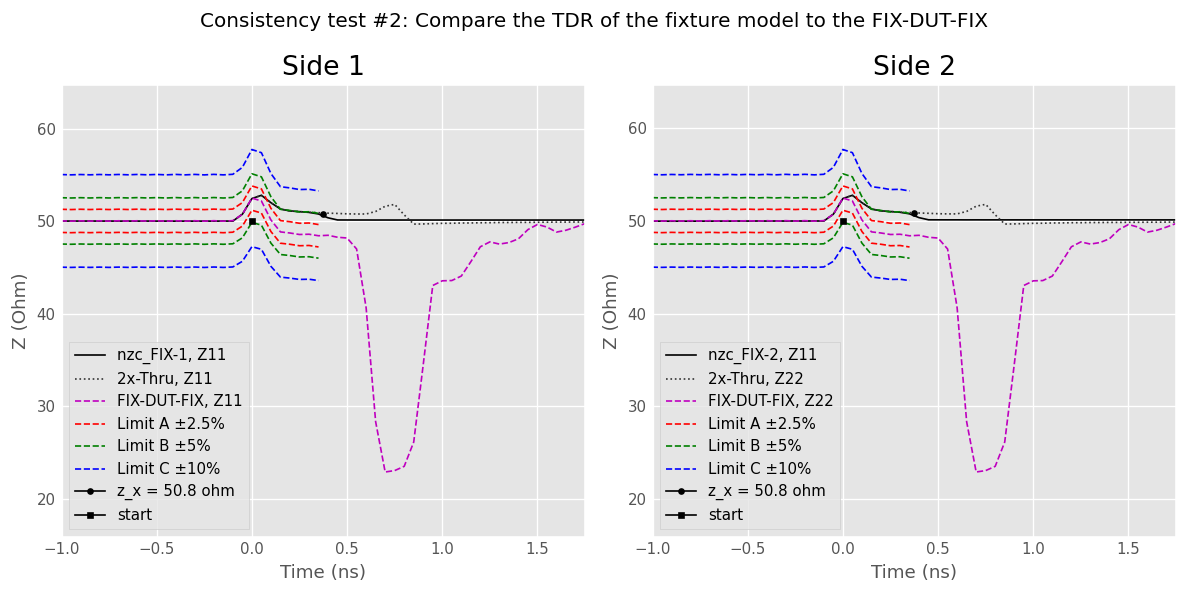

In [7]:
fig, ax = dm_nzc.plot_check_impedance(fdf)

Both fixtures are out of the maximum ±10 % impedance variation compared to FIX-DUT-FIX. This is because we exagerated the impedance difference between 2x-Thru and FIX-DUT-FIX for demonstration purpose. The fixtures agrees well with 2x-Thru.

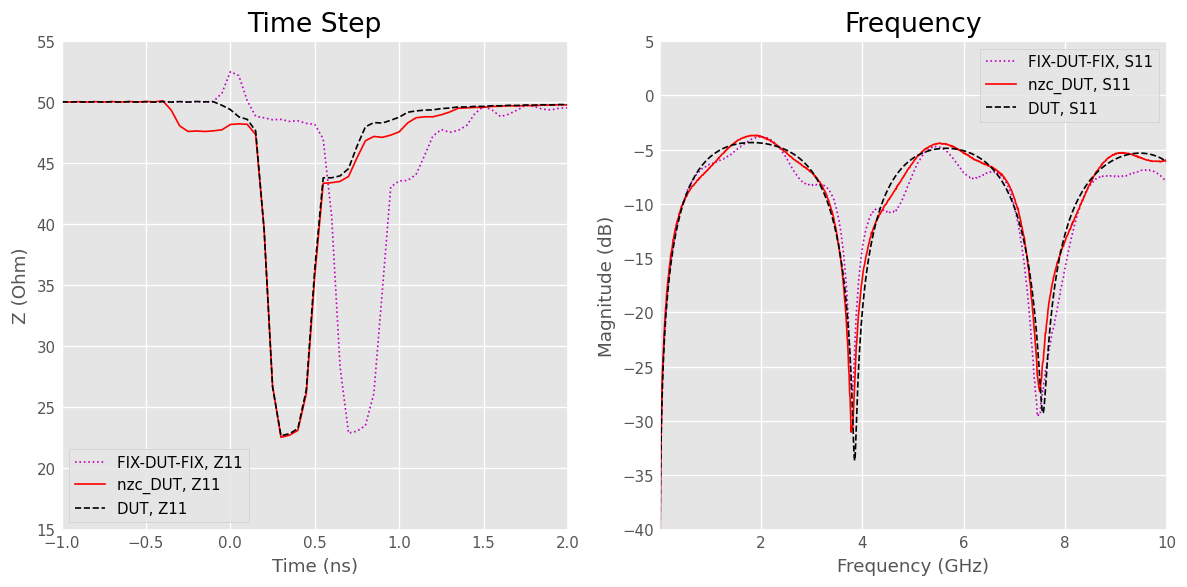

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Time Step')
fdf_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dotted', color = 'm')
nzc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
dut_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].set_xlim((-1, 2))
axs[0].set_ylim((15, 55))
axs[0].legend(loc = 'lower left')

axs[1].set_title('Frequency')
fdf.plot_s_db(0, 0, ax = axs[1], color = 'm', linestyle = 'dotted')
nzc_d_dut.plot_s_db(0, 0, ax = axs[1], color = 'r')
dut.plot_s_db(0, 0, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].set_ylim((-40, 5))
fig.tight_layout()

The NZC deembedding has removed the delay of the fixture but, as expected, the difference of impedance between FIX-FIX and FIX-DUT-FIX are causing an impedance bounce in timestep.

### IEEEP370_SE_ZC_2xThru with impedance correction <a class="anchor" id="zc"></a>
This method take 2x-Thru and FIX-DUT-FIX as inputs. It makes a correction for the (unwanted) difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX.

The algorithm computes the length of the fixtures by halving the length of 2x-Thru. It then peels iteratively FIX-DUT-FIX by determining start impedance in time-domain, deembedding a one time sample long transmission line of this impedance and loop again until the fixtures mimic FIX-DUT-FIX sides impedance profile. This is different of IEEEP370_SE_NZC_2xThru that only does a bissection of 2x-Tru S-parameters.

IEEEP370_SE_ZC_2xThru has more options and often give better results than IEEEP370_SE_NZC_2xThru, but it consumes more processing power.

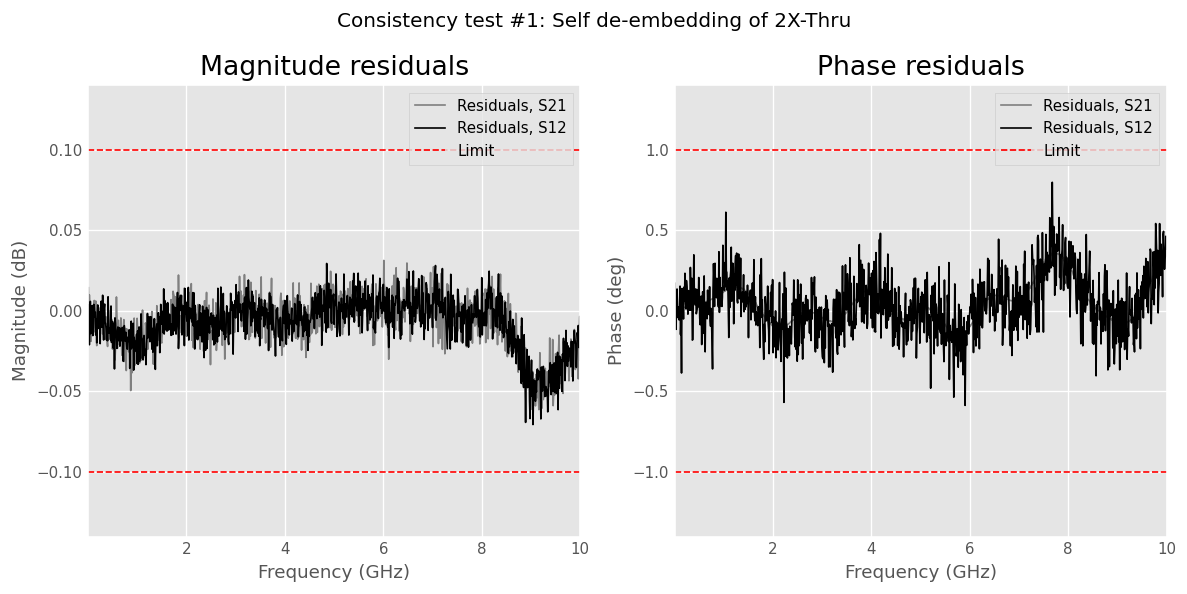

In [17]:
dm_zc  = IEEEP370_SE_ZC_2xThru(dummy_2xthru = s2xthru, dummy_fix_dut_fix = fdf,
                         bandwidth_limit = 10e9, pullback1 = 0, pullback2 = 0,
                         leadin = 1, NRP_enable = True,
                         name = 'zc2xthru')
zc_d_dut = dm_zc.deembed(fdf)
zc_d_dut.name = 'zc_DUT'
zc_fix1 = dm_zc.s_side1
zc_fix1.name = 'zc_FIX-1'
zc_fix2 = dm_zc.s_side2
zc_fix2.name = 'zc_FIX-2'
zc_fix1_dc = IEEEP370.extrapolate_to_dc(zc_fix1)
zc_d_dut_dc = IEEEP370.extrapolate_to_dc(zc_d_dut)

fig, ax = dm_zc.plot_check_residuals()

The residuals magnitude of fixture and 2xthru is more significant than with NZC, but it still fit into IEEEP370 ±0.1 dB limit. This is because of the artificially added impedance mismatch between fixture and 2x-Thru. The residual phase is kept within the IEEEP370 limits of ±1°, which is not bad. 

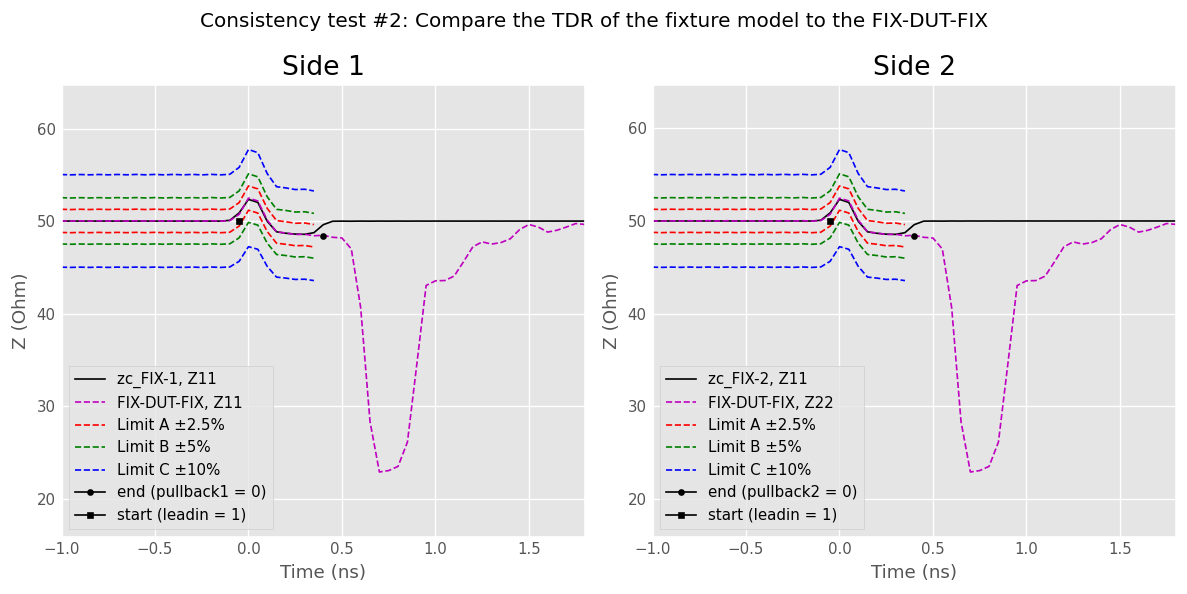

In [18]:
fig, ax = dm_zc.plot_check_impedance()

The agreement of time domain is within ±2.5 % (and even better) thanks, to impedance correction. The fixture now mimics the FIX-DUT-FIX and not the 2x-Thru, except for the length determination. 

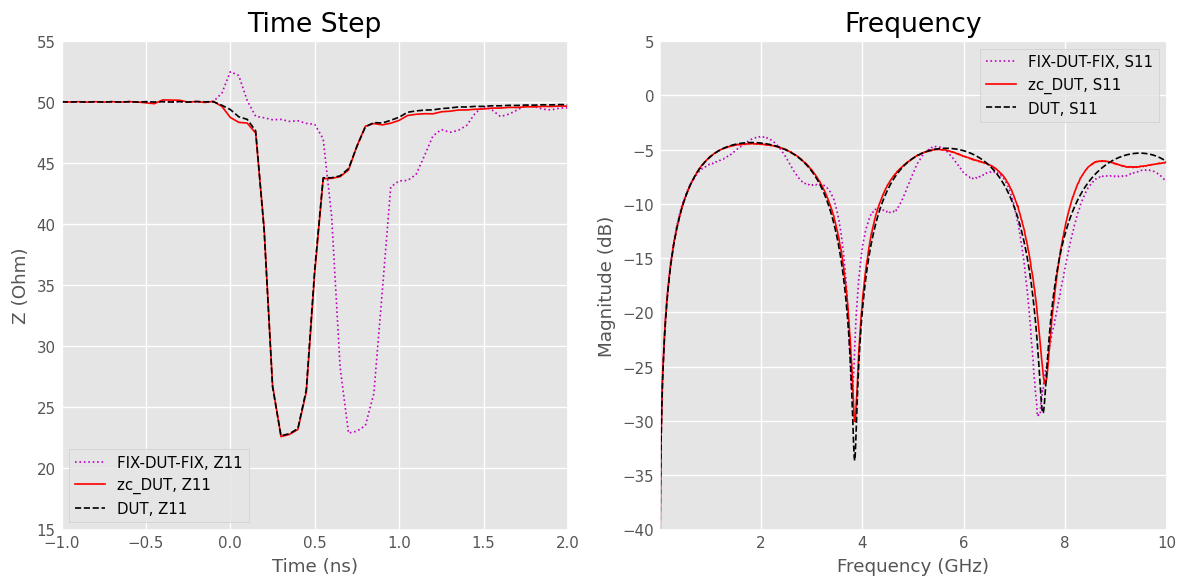

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Time Step')
fdf_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dotted', color = 'm')
zc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
dut_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].set_xlim((-1, 2))
axs[0].set_ylim((15, 55))
axs[0].legend(loc = 'lower left')

axs[1].set_title('Frequency')
fdf.plot_s_db(0, 0, ax = axs[1], color = 'm', linestyle = 'dotted')
zc_d_dut.plot_s_db(0, 0, ax = axs[1], color = 'r')
dut.plot_s_db(0, 0, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].set_ylim((-40, 5))
fig.tight_layout()

As expected, the ZC deembedding shows a better agreement on time step than NZC. This is because ZC compensates the slight impedance difference between FIX-FIX and FIX-DUT-FIX of this example. Of course, this difference should be minimized as much as possible at the manufacturing stage.

### Single Ended Comparison with AICC De-Embedding Utility <a class="anchor" id="aicc"></a>
A set of reference Matlab or Octave codes that implement the IEEEP370 NZC and ZC deembedding algorithms are available with an open source BSD-3-Clause license [on IEEE repo](https://opensource.ieee.org/elec-char/ieee-370/-/tree/master/TG1)

However, not everyone has access to Matlab and RF Toolbox. Maybe, is this one of the reasons why you are reading this text and looking forward to using `scikit-rf` and Python.

A compiled binary of Matlab routine with a gui is available [on Amphenol website](https://www.amphenol-cs.com/software) with the name "ACS De-embedding Utility".
<img src="ieeep370deembedding/AICC_Deembedding.png">

Let's compare the output of this tool on `scikit-rf` port of deembedding algorithms as a consistency-check.

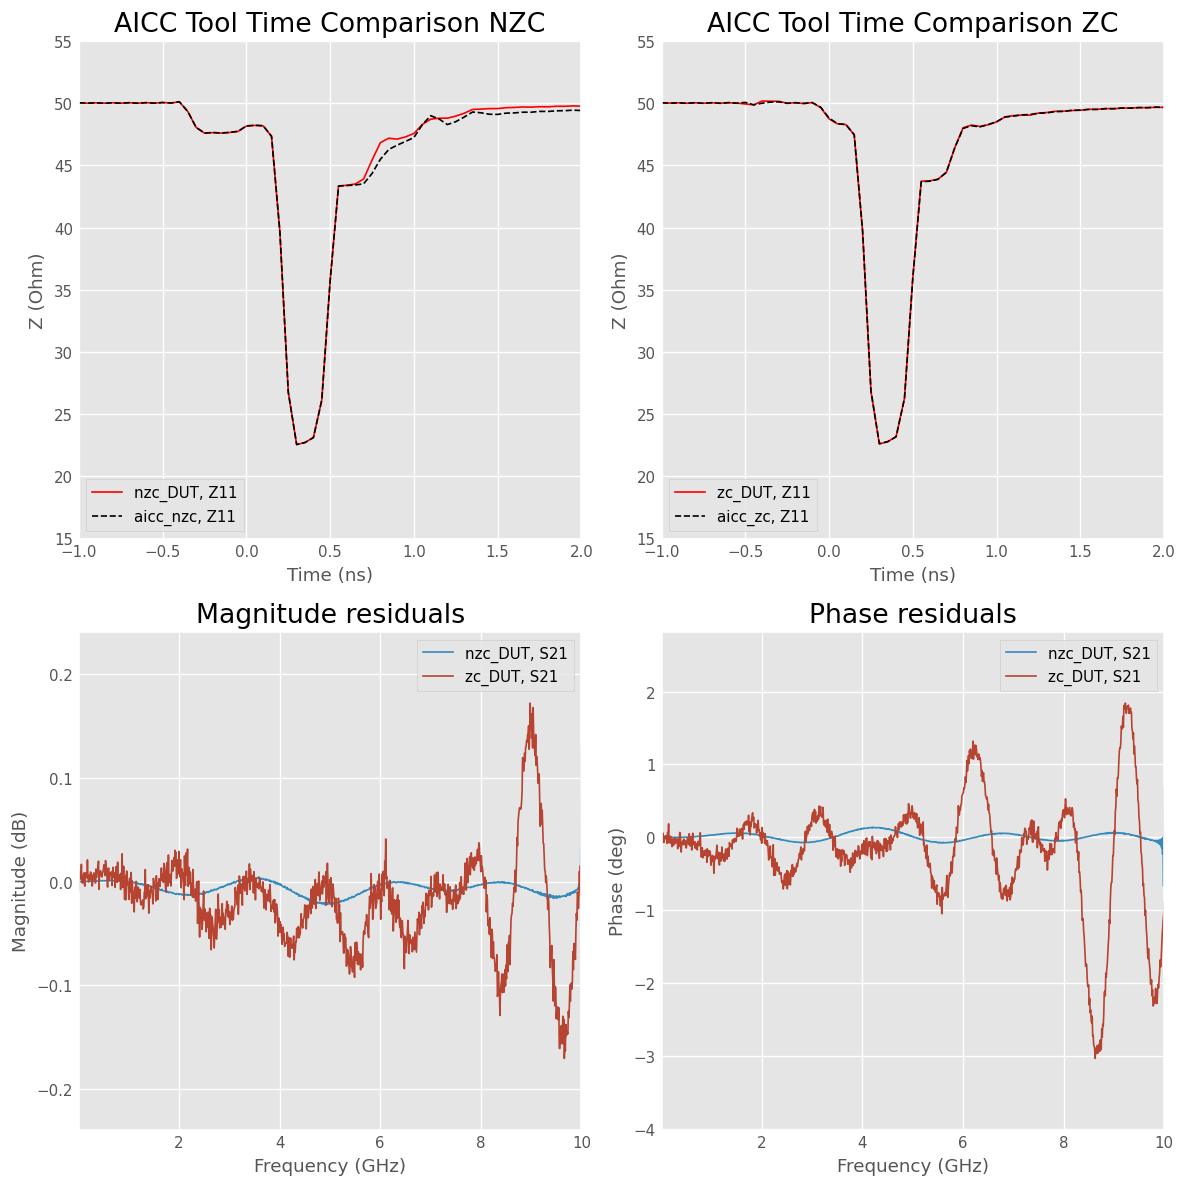

In [20]:
# read AICC generated files
nzc_ref = rf.Network(directory + 'deembedded_SE_NZC_se_fdf.s2p')
nzc_ref.name = 'aicc_nzc'
zc_ref = rf.Network(directory + 'deembedded_SE_ZC_se_fdf.s2p')
zc_ref.name = 'aicc_zc'
nzc_ref_dc = IEEEP370.extrapolate_to_dc(nzc_ref)
zc_ref_dc = IEEEP370.extrapolate_to_dc(zc_ref)

# compute residuals
res_nzc2 = nzc_d_dut.inv ** nzc_ref
res_zc2 = zc_d_dut.inv ** zc_ref

# plot them all
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].set_title('AICC Tool Time Comparison NZC')
nzc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0, 0], color = 'r')
nzc_ref_dc.plot_z_time_step(0, 0, ax = axs[0, 0], linestyle = 'dashed', color = 'k')
axs[0, 0].legend(loc = 'lower left')
axs[0, 0].set_xlim((-1, 2))
axs[0, 0].set_ylim((15, 55))

axs[0, 1].set_title('AICC Tool Time Comparison ZC')
zc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0, 1], color = 'r')
zc_ref_dc.plot_z_time_step(0, 0, ax = axs[0, 1], linestyle = 'dashed', color = 'k')
axs[0, 1].legend(loc = 'lower left')
axs[0, 1].set_xlim((-1, 2))
axs[0, 1].set_ylim((15, 55))

axs[1, 0].set_title('Magnitude residuals')
res_nzc2.plot_s_db(1,0, ax = axs[1, 0])
res_zc2.plot_s_db(1,0, ax = axs[1, 0])

axs[1, 1].set_title('Phase residuals')
res_nzc2.plot_s_deg(1,0, ax = axs[1, 1])
res_zc2.plot_s_deg(1,0, ax = axs[1, 1])
plt.tight_layout()

Both NZC and ZC show visually a good agreement in time domain plots. The residuals phase and magnitude of NZC against AICC tool are small according to IEEEP370 limits. The magnitude and phase of ZC are within the 0.1 dB and 1° limit up to 9 GHz. The small high-frequency deviation would not affect the time step shape very much.

In conclusion, for the specific single-ended case studied, we can say that `scikit-rf` give consistent results with `AICC De-embedding Utility` implementation if IEEEP370 deembedding routines.

## Mixed mode <a class="anchor" id="mixed-mode"></a>
ZC and NZC deembedding can also be used on differential 4-port measurements thanks to single-ended to generalized mixed mode parameters transformation. Two Thrus are modeled, respectively for differential and for common modes and mixed back into a single-ended fixture model that can be deembedded from measurement.

### Simulation of 2xThru, DUT and Fixture-DUT-Fixture <a class="anchor" id="mm-preparation"></a>
We use [Qucs](http://qucs.sourceforge.net/) to simulate coupled microstrip lines artifacts. This is a free simulator that can generate s-parameters of equation-based RF devices, among other things.

* `diff_dut` is a Beatty structure with a 3xWidth segment connected left and right by two uniform 1xWidth coupled microstrip.
* `diff_fdf` is Fixture-DUT-Fixture, prolongating the DUT left and right lines (connector and launch not simulated).
* `diff_2xthru` is Fixture-Fixture and is the two prolongating lines connected in the middle without the DUT. For example purpose the width is changed by 20% to show the effect of such a mismatch in the deembedding process.

<img src="ieeep370deembedding/diff_fdf.png">

The files as well as `qucs` sources are located in the directory `ieeep370deembedding` next to this notebook. 

### IEEEP370_MM_NZC_2xThru without impedance correction <a class="anchor" id="mmnzc"></a>
This method only takes 2x-Thru as input. It is quite simple and efficient but cannot correct for the difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX. Of course this difference is not wanted, but it could occurs depending manufacturing process or if the artefacts are not built on the same board.

In [13]:
# load single-ended data
se_ref_nzc = rf.Network(directory + 'deembedded_MM_NZC_diff_fdf.s4p')
se_ref_nzc.name = 'aicc_nzc'
se_dut = rf.Network(directory + 'diff_dut.s4p')
se_2xthru = rf.Network(directory + 'diff_2xthru.s4p')
se_fdf = rf.Network(directory + 'diff_fdf.s4p')

# transform to mixed-modes
mm_ref_nzc = se_ref_nzc.copy()
mm_ref_nzc.se2gmm(p = 2)
mm_2xthru = se_2xthru.copy()
mm_2xthru.se2gmm(p = 2)
mm_fdf = se_fdf.copy()
mm_fdf.se2gmm(p = 2)
mm_dut = se_dut.copy()
mm_dut.se2gmm(p = 2)

# extrapolate to DC for time step
mm_2xthru_dc = IEEEP370.extrapolate_to_dc(mm_2xthru)
mm_ref_nzc_dc = IEEEP370.extrapolate_to_dc(mm_ref_nzc)
mm_dut_dc = IEEEP370.extrapolate_to_dc(mm_dut)
mm_fdf_dc = IEEEP370.extrapolate_to_dc(mm_fdf)

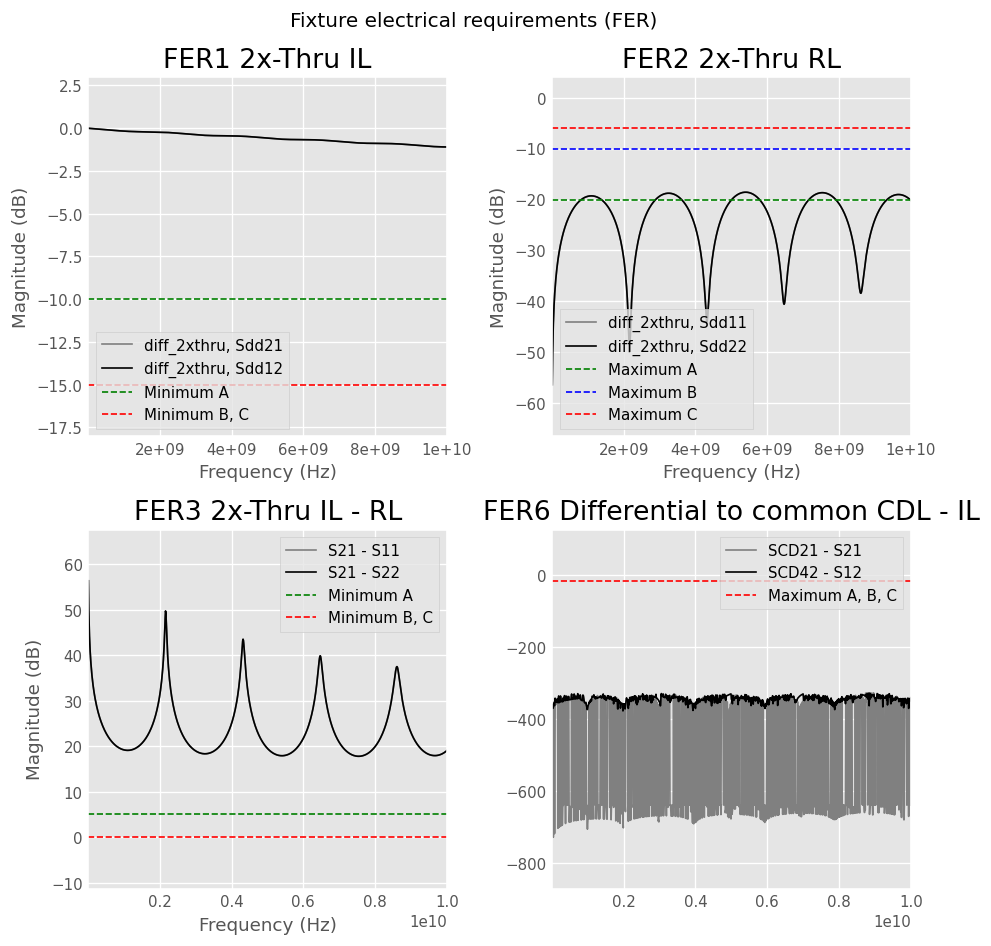

In [14]:
fig = IEEEP370.plot_check_mm_fer_s(se_2xthru)

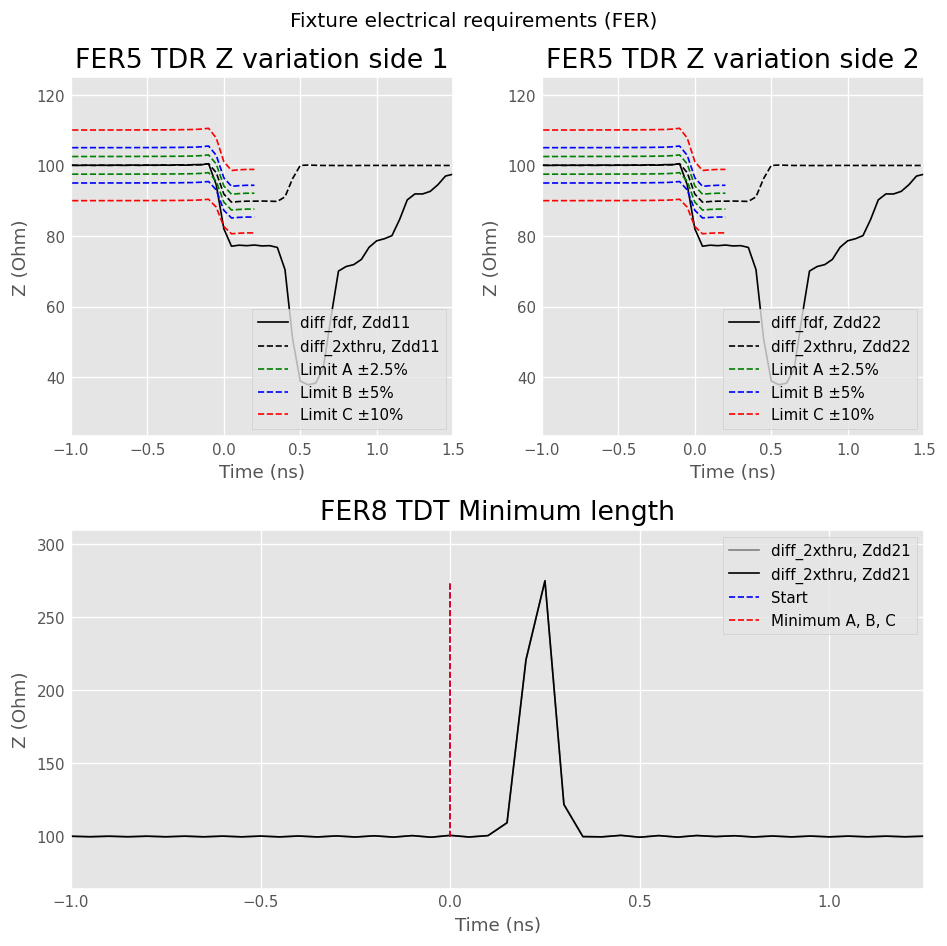

In [15]:
fig = IEEEP370.plot_check_mm_fer_z(se_2xthru, se_fdf)

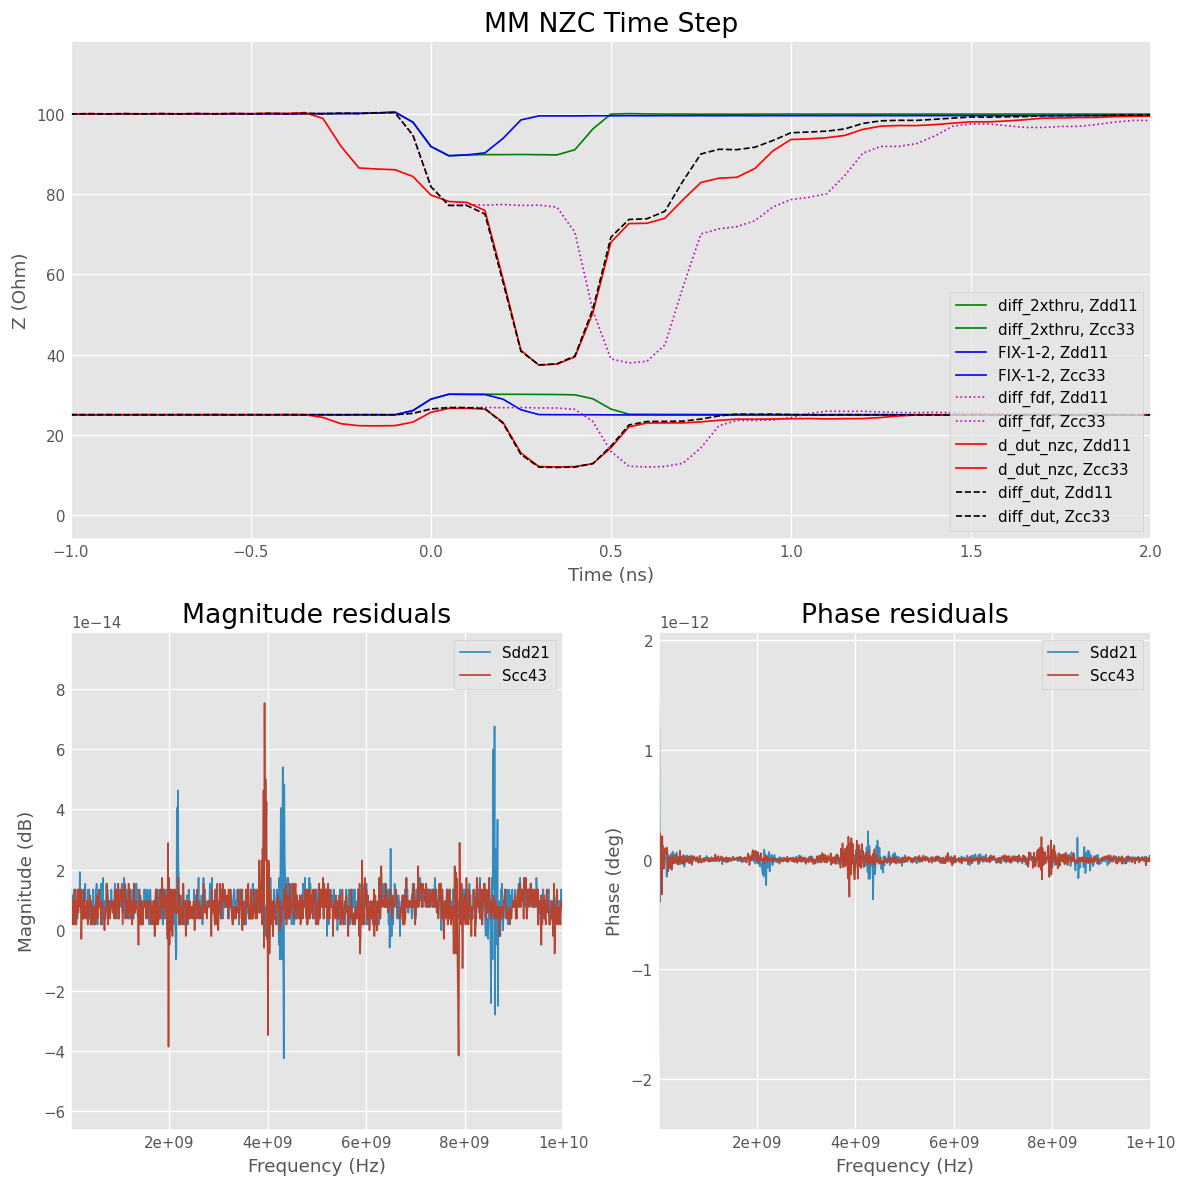

In [121]:
# de-embedding
z0 = 50
dm_mmnzc  = IEEEP370_MM_NZC_2xThru(dummy_2xthru = se_2xthru, z0 = z0, name = 'mmnzc')
se_d_dut_nzc = dm_mmnzc.deembed(se_fdf)
se_d_dut_nzc.name = 'd_dut_nzc'
mm_d_dut_nzc = se_d_dut_nzc.copy()
mm_d_dut_nzc.se2gmm(p = 2)
mm_nzc_side1 = dm_mmnzc.se_side1.copy()
mm_nzc_side1.name = 'FIX-1-2'
mm_nzc_side1.se2gmm(p = 2)
mm_d_dut_nzc_dc = IEEEP370.extrapolate_to_dc(mm_d_dut_nzc)
mm_nzc_side1_dc = IEEEP370.extrapolate_to_dc(mm_nzc_side1)

# residuals for consistency check
mm_res_nzc = dm_mmnzc.deembed(se_2xthru)
mm_res_nzc.se2gmm(p = 2)
mm_res_nzc.s += 1e-15 # avoid numeric singularities
mm_res_nzc_dc = IEEEP370.extrapolate_to_dc(mm_res_nzc)

# plot them all
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.title('MM NZC Time Step')
mm_2xthru_dc.plot_z_time_step(0, 0, color = 'g')
mm_2xthru_dc.plot_z_time_step(2, 2, color = 'g')
mm_nzc_side1_dc.plot_z_time_step(0, 0, color = 'b')
mm_nzc_side1_dc.plot_z_time_step(2, 2, color = 'b')
mm_fdf_dc.plot_z_time_step(0, 0, color = 'm', linestyle='dotted')
mm_fdf_dc.plot_z_time_step(2, 2, color = 'm', linestyle='dotted')
mm_d_dut_nzc_dc.plot_z_time_step(0, 0, color = 'r')
mm_d_dut_nzc_dc.plot_z_time_step(2, 2, color = 'r')
mm_dut_dc.plot_z_time_step(0, 0, color = 'k', linestyle='dashed')
mm_dut_dc.plot_z_time_step(2, 2, color = 'k', linestyle='dashed')
plt.xlim((-1, 2))
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.title('Magnitude residuals')
mm_res_nzc.plot_s_db(1, 0)
mm_res_nzc.plot_s_db(3, 2)

plt.subplot(2, 2, 4)
plt.title('Phase residuals')
mm_res_nzc.plot_s_deg(1, 0)
mm_res_nzc.plot_s_deg(3, 2)
mm_res_nzc.name = 'Residuals'
plt.tight_layout()

As expected, the impedance mismatch between 2xthru and FIX-DUT-FIX cause an impedance bounce in deembedded DUT.

Residuals computed by deembedding the 2xthru to check consistency shows results that are very small both in magnitude and phase. Both are within the IEEEP370 ±0.1 dB and ±1° limits on full bandwidth.

### IEEEP370_MM_ZC_2xThru with impedance correction <a class="anchor" id="mmzc"></a>
This method take 2x-Thru and FIX-DUT-FIX as inputs. It makes a correction for the (unwanted) difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX.

The algorithm computes the length of the fixtures by halving the length of 2x-Thru. It then peels iteratively FIX-DUT-FIX by determining start impedance in time-domain, deembedding a one time sample long transmission line of this impedance and loop again until the fixtures mimic FIX-DUT-FIX sides impedance profile. This is different of IEEEP370_MM_NZC_2xThru that only does a bissection of 2x-Tru S-parameters.

IEEEP370_MM_ZC_2xThru has more options and often give better results than IEEEP370_MM_NZC_2xThru, but it consumes more processing power.

In [ ]:
# load single-ended data
se_ref_zc = rf.Network(directory + 'deembedded_MM_ZC_diff_fdf.s4p')
se_ref_zc.name = 'aicc_zc'

# transform to mixed-modes
mm_ref_zc = se_ref_zc.copy()
mm_ref_zc.se2gmm(p = 2)

# extrapolate to DC for time step
mm_ref_zc_dc = IEEEP370_SE_ZC_2xThru.extrapolate_to_dc(mm_ref_zc)

# de-embedding
dm_mmzc  = IEEEP370_MM_ZC_2xThru(dummy_2xthru = se_2xthru, dummy_fix_dut_fix = se_fdf,
                         bandwidth_limit = 10e9, pullback1 = 0, pullback2 = 0,
                         leadin = 0, NRP_enable = False, name = 'mmzc')
se_d_dut_zc = dm_mmzc.deembed(se_fdf)
se_d_dut_zc.name = 'd_dut_zc'
mm_d_dut_zc = se_d_dut_zc.copy()
mm_d_dut_zc.se2gmm(p = 2)
mm_zc_side1 = dm_mmzc.se_side1.copy()
mm_zc_side1.name = 'FIX-1-2'
mm_zc_side1.se2gmm(p = 2)
mm_d_dut_zc_dc = IEEEP370.extrapolate_to_dc(mm_d_dut_zc)
mm_zc_side1_dc = IEEEP370.extrapolate_to_dc(mm_zc_side1)

# residuals for consistency check
mm_res_zc = dm_mmzc.deembed(se_2xthru)
mm_res_zc.name = 'Residuals'
mm_res_zc.se2gmm(p = 2)
mm_res_zc.s += 1e-15 # avoid numeric singularities
mm_res_zc_dc = IEEEP370_SE_ZC_2xThru.extrapolate_to_dc(mm_res_zc)

# plot them all
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.title('MM NZC Time Step')
mm_2xthru_dc.plot_z_time_step(0, 0, color = 'g')
mm_2xthru_dc.plot_z_time_step(2, 2, color = 'g')
mm_zc_side1_dc.plot_z_time_step(0, 0, color = 'b')
mm_zc_side1_dc.plot_z_time_step(2, 2, color = 'b')
mm_fdf_dc.plot_z_time_step(0, 0, color = 'm', linestyle='dotted')
mm_fdf_dc.plot_z_time_step(2, 2, color = 'm', linestyle='dotted')
mm_d_dut_zc_dc.plot_z_time_step(0, 0, color = 'r')
mm_d_dut_zc_dc.plot_z_time_step(2, 2, color = 'r')
mm_dut_dc.plot_z_time_step(0, 0, color = 'k', linestyle='dashed')
mm_dut_dc.plot_z_time_step(2, 2, color = 'k', linestyle='dashed')
plt.xlim((-1, 2))
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.title('Magnitude residuals')
mm_res_zc.plot_s_db(1, 0)
mm_res_zc.plot_s_db(3, 2)
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Phase residuals')
mm_res_zc.plot_s_deg(1, 0)
mm_res_zc.plot_s_deg(3, 2)
plt.legend(loc='upper right')
plt.tight_layout()

The plot show that the impedance mismatch between 2x-Thru and FIX-DUT-FIX has been corrected for the computation of fixture side1.

The phase and magnitude residuals are out from the ±0.1 dB and ±1° boundaries, but not from that much.

Remember that we artificially introduce an impedance mismatch between 2x-Thru, and FIX-DUT-FIX and that the fixtures now mimic FIX-DUT-FIX. As such, the agreement between 2xThru and FIX-FIX cannot be good.

### Mixed Mode Comparison with AICC De-Embedding Utility <a class="anchor" id="mmaicc"></a>
Let's compare the deembedded DUTs from `scikit-rf` and `AICC De-Embedding Utility` to conclude this notebook.

In [ ]:
mm_nzc_residuals = se_d_dut_nzc.inv ** se_ref_nzc
mm_nzc_residuals.se2gmm(p = 2)
mm_nzc_residuals.s += 1e-15 # avoid numeric singularities
mm_zc_residuals = se_d_dut_zc.inv ** se_ref_zc
mm_zc_residuals.se2gmm(p = 2)
mm_zc_residuals.s += 1e-15 # avoid numeric singularities

# plot them all
plt.figure(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.title('AICC Tool Time Comparison NZC')
mm_d_dut_nzc_dc.plot_z_time_step(0, 0, color = 'r')
mm_d_dut_nzc_dc.plot_z_time_step(2, 2, color = 'b')
mm_ref_nzc_dc.plot_z_time_step(0, 0, linestyle='dashed', color = 'k')
mm_ref_nzc_dc.plot_z_time_step(2, 2, linestyle='dashed', color = 'k')
plt.xlim((-1, 2))
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.title('AICC Tool Time Comparison ZC')
mm_d_dut_zc_dc.plot_z_time_step(0, 0, color = 'r')
mm_d_dut_zc_dc.plot_z_time_step(2, 2, color = 'b')
mm_ref_zc_dc.plot_z_time_step(0, 0, linestyle='dashed', color = 'k')
mm_ref_zc_dc.plot_z_time_step(2, 2, linestyle='dashed', color = 'k')
plt.xlim((-1, 2))
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.title('Magnitude Residuals')
mm_nzc_residuals.plot_s_db(1, 0)
mm_nzc_residuals.plot_s_db(3, 2)
mm_zc_residuals.plot_s_db(1, 0)
mm_zc_residuals.plot_s_db(3, 2)
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.title('Phase Residuals')
mm_nzc_residuals.plot_s_deg(1, 0,)
mm_nzc_residuals.plot_s_deg(3, 2)
mm_zc_residuals.plot_s_deg(1, 0)
mm_zc_residuals.plot_s_deg(3, 2)
plt.legend(loc='upper right')
plt.tight_layout()

The agreement between `scikit-rf` and `AICC De-Embedding Utility` is good both visually in time domain and on magnitude and phase residuals that are within ±0.4 dB and ±2° on full bandwidth. The agreement is even better for the NZC algorithm.

In conclusion, for the specific mixed mode case studied, we can say that `scikit-rf` gives reasonably consistent results with `AICC De-embedding Utility` implementation in IEEEP370 deembedding routines.